## Ayudantía 10:  Networking

#### Autores: @lucasvsj, @fvidalf & @pedrozavalat


Puedes evaluar esta ayudantía [en este link](https://docs.google.com/forms/d/e/1FAIpQLSesBxOc3Ux5hR-da2I1dJJHW-ym9Ho5VDVjCiM4nCYPMmm7tQ/viewform?usp=sf_link)

En esta ayudantía aprenderemos lo básico de Networking con interfaces gráficas fundamentalmente a través de la implementación en Python.

## ¿Qué es Networking?
Hasta ahora sabemos cómo leer y escribir archivos (ej. archivos csv) y también a correr tareas pseudo-simultáneamente a través de threads. 

Sin embargo, no sabemos cómo hacer que dos o más **programas independientes interactúen entre sí**. Para eso utilizamos Networking.

<center>
    
![title](img/intro.png)
</center>

## Networking en Python
En Python, utilizamos la librería ```socket``` para programar con Networking. 

Esta librería tiene al objeto socket, encargado de manejar la comunicación entre los distintos programas.

![title](img/summary.png)

## Flujo Networking

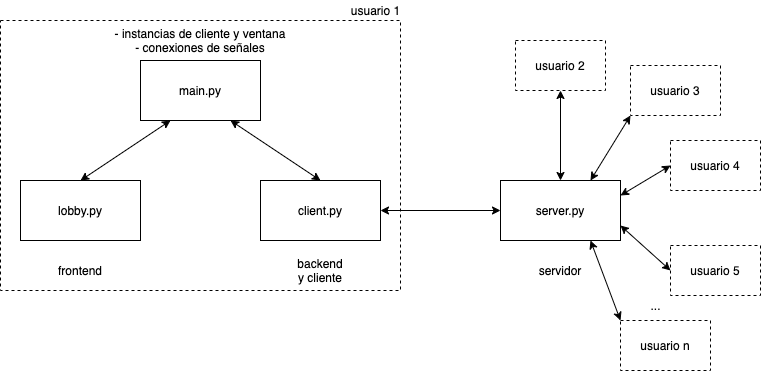

# DCChat

*Ehem... Es el año 2023, y la tradición del DCC de usar Telegram está en peligro. ¡Ya no da a basto! Tanto spam en el grupo DCCommunity finalmente está pasando factura, por lo que se les ha encargado a los para-nada-agotados ayudantes Tareos de Avanzada el construir una alternativa made-in-DCC (todo esto bajo el ojo vigilante de los Docencios que "supervisan" tomándose un café).*

Luego de incontables noches de incesante trabajo, finalmente se ha decidido el nombre: ¡DCChat! Un sencillo servicio de mensajería, donde los usuarios envían mensajes a un servidor, el cual a su vez los retransmite hacia todos los usuarios conectados.

### A modo general...

- El servidor debe poder escuchar a múltiples clientes de forma simultánea (psst, va a haber _threading_)

- Debe tener alguna referencia a los usuarios conectados, ya que además de escuchar, debe ser capaz de enviar respuestas. Para los usuarios es similar, excepto que interactúan con un único servidor.

- En _networking_, las conexiones y transmisiones no son siempre estables y pueden ocurrir errores, por lo que debemos estar preparados para lidiar con ellos.

<h1> ServidorChat.py </h1>

- Primero creamos el Servidor, donde definimos el _host_ y el _port_ y creamos el socket con el protocolo de transporte de datos TCP (socket.SOCK_STREAM) y el tipo de dirección IP (socket.AF_INET). 

- Además creamos un diccionario donde guardaremos los sockets de los Clientes y llamamos a las funciones necesarias para que el Servidor funcione.

In [ ]:
class Servidor:


    def __init__(self, port, host):
        self.max_recv = 2**16
        self.host = host
        self.port = port
        self.socket_server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sockets = {}
        self.bind_listen()
        self.accept_connections()

### bind_listen

Con este método, **asociamos el servidor al host y puerto** que le pasamos en el ```__init__()```, luego decidimos la cantidad de Clientes que va a  permitir que se conecten.

In [ ]:
    def bind_listen(self):
        self.socket_server.bind((self.host, self.port))
        self.socket_server.listen(250)
        print(f'Servidor escuchando en {self.host} : {self.port}')

### accept_connections

En este método **creamos el Thread** encargado de aceptar las nuevas conexiones que lleguen al Servidor, para luego iniciarlo.

In [1]:
    def accept_connections(self):
        thread = threading.Thread(
            target=self.accept_connections_thread)
        thread.start()

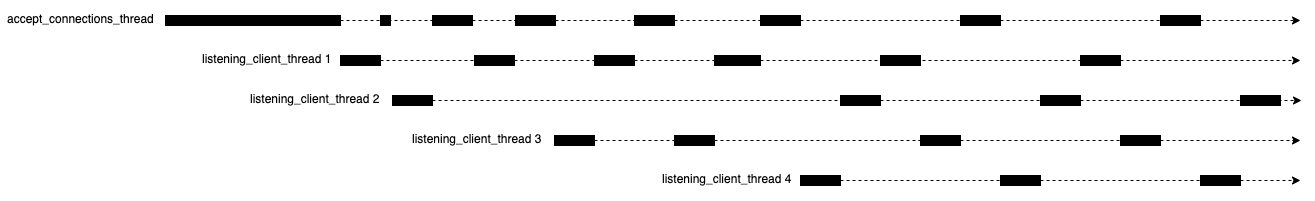

### accept_connections_thread

Este es el metodo que ejecuta el Thread anterior. **Encargado de aceptar conexiones**, guarda el socket que se esta conectando (en la variable ```client_socket```) y su respectivo address (en la variable ```address```). 

Vale destacar que el address no es del todo útil, y puede como no ser guardado. Luego se **crea el Thread encargado de estar escuchando** a dicho socket y lo echamos a andar.

In [ ]:
    def accept_connections_thread(self):
        while True:
            client_socket, address = self.socket_server.accept()
            self.sockets[client_socket] = address
            listening_client_thread = threading.Thread( \
                target=self.listen_client_thread, \
                args=(client_socket, ), \
                daemon=True)
            listening_client_thread.start()

### listen_client_thread

Este es el método que ejecuta el Thread recién creado. **Encargado de escuchar a un Cliente**, en este, se genera un loop que recibe el mensaje que manda el Cliente y luego prosigue a decodificarlo para luego entregárselo a método encargado de qué hacer con dicha información.

In [ ]:
    def listen_client_thread(self, client_socket):
        while True:
            largo_archivo = int.from_bytes(
                client_socket.recv(4), byteorder='big')
            if largo_archivo > self.max_recv:
                largo_archivo = self.max_recv
            bytes_leidos = bytearray()
            while len(bytes_leidos) < largo_archivo:
                # El último recv será probablemente más chico que 4096
                bytes_leer = min(4096, largo_archivo - len(bytes_leidos))
                respuesta = client_socket.recv(bytes_leer)
                bytes_leidos += respuesta
            try:
            # Si se elimina el usuario, el servidor recibe un mensaje vacío y no logra
            # deserializarlo.
                mensaje_entero = json.loads(bytes_leidos)
                self.chat_management(mensaje_entero)
            except json.decoder.JSONDecodeError as e:
                print('Usuario eliminado')
            # Eliminamos al cliente del diccionario de sockets
                del self.sockets[client_socket]
                break

### chat_management

Este método es el encargado de leer el mensaje que llega desde el Cliente y luego enviar la información (manejada por el Servidor) a cada Cliente conectado.

In [ ]:
    def chat_management(self, msg):
        msg_to_send = { "type" : msg["type"], \
                        "username" : msg["username"], \
                        "data" : msg["data"]}
        for skt in self.sockets.keys():
            self.custom_send(msg_to_send, skt)

### custom_send 

Este es el método encargado de enviar la información de manera encriptada (bytes) y es donde se llama a sock.send (el método que envia la información al socket (Cliente))

In [ ]:
    def custom_send(self, value, sock):
        str_value = str(value)
        msg_bytes = str_value.encode()
        sock.send(msg_bytes)

# Cliente.py

- Este puede ser más complejo que el Servidor, ya que posee caracteristicas de Networking (sockets) y de Interfaz de Usuario (QObject). 

- Esto se debe a que Cliente tiene la responsabilidad extra de estar encargado del Backend del DCChat (donde el archivo lobby.py es su Frontend). 

Dicho eso, a grandes rasgos debemos hacer...

### Networking

- Definimos el host y el port y creamos el socket con el protocolo de transporte de datos TCP (socket.SOCK_STREAM) y el tipo de dirección IP (socket.AF_INET). 

- Luego debemos tratar de conectarnos al servidor (tratamos porque no siempre se garantiza una conección éxitosa), por lo que aplicamos un try/except en donde en el try se llaman a los métodos encargados de conectarse y en el except se cierra el socket y se detiene el programa. 

### Backend

Definimos las señales necesarias para que exista comunicación con el Frontend y las distintas variables y métodos que implementarían la lógica.

In [ ]:
class Cliente(QObject):


    update_lobby_chat = pyqtSignal(str)
    send_username = pyqtSignal(str)


    def __init__(self, port, host):
        super().__init__()
        print('Creando cliente')
        self.port = port
        self.host = host
        self.socket_cliente = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.username = 'User' + ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
        try:
            self.connect_to_server()
            self.listen()
            self.initBackend()
        except ConnectionError:
            print('Conexion terminada')
            self.socket_cliente.close()
            self.isConnected = False
            exit()
            

Revisemos ahora los métodos implementados

### connect_to_server
En este método se realiza la conexión con el Servidor


In [ ]:
    def connect_to_server(self):
        self.socket_cliente.connect((self.host, self.port))
        print('Cliente conectado a servidor')

### listen

En este método se __crea el Thread__ encargado de escuchar al Servidor y  luego hacemos que corra.

In [ ]:
    def listen(self):
        thread = threading.Thread(target=self.listen_thread, daemon=True)
        thread.start()

### listen_thread

Este es el método que ejecuta el Thread encargado de escuchar al Servidor. Aquí, se genera un loop que __recibe el mensaje que manda el Servidor__ y luego prosigue a __decodificarlo__ y a entregárselo al método encargado de qué hacer con dicha información.

In [1]:
    def listen_thread(self):
        while self.isConnected:
            data = self.socket_cliente.recv(2**16)
            decoded_data = data.decode()
            decoded_data = decoded_data.replace('\'', '\"') #Esto lo hacemos porque json solo acepta el "", no el ''
            data = json.loads(decoded_data)
            self.decode_msg_from_server(data)
            pass

### send

En este método, encriptamos la información y la enviamos al Servidor.

In [ ]:
    def send(self, msg):
        json_msg = json.dumps(msg)
        msg_to_send = json_msg.encode()
        largo = len(msg_to_send)
        self.socket_cliente.send(largo.to_bytes(4, byteorder='big') + msg_to_send)

Veamos rápidamente como interactúa el Backend de la aplicación DCChat con la implementación del cliente.

### init_backend

Creamos las variables self.isConnected, la cual es la condicion del while en el método self.listen_thread() y la variable self.chat, donde guardaremos el chat del DCChat (todos los mensajes que han sido enviados) para luego poder mostrarlos en el Frontend. 

In [ ]:
    def init_backend(self):
        self.isConnected = True
        self.chat = ''

### send_init_info_to_chat

Este método se encarga de enviar el nombre de usuario al frontend del DCChat 

### receive_msg_from_lobby

Este método se encarga de recibir  la información del Frontend del DCChat (el mensaje que quiere enviar el usuario) y de enviarlo al Servidor (puesto que no debemos "manejarlo").

In [ ]:
    def send_init_info_to_chat(self):
        self.send_username.emit(self.username)
        
    def receive_msg_from_lobby(self, event):
        self.send(event)

### decode_msg_from_server

Este método es el encargado de decodificar la información recibida por el Servidor, agregarlo a self.chat y finalmente mandar la información al Backend.

In [ ]:
    def decode_msg_from_server(self, msg):
        string_to_add = f'{msg["username"]}: {msg["data"]}\n'
        self.chat += string_to_add
        self.update_lobby_chat.emit(self.chat)